# Historgram and Boxplots

In [2]:
from utils import misc
loaded_data = misc.load_json_files(f"output/continue_generation")

In [ ]:
from collections import defaultdict
import numpy as np

bleu = []
rough_l = []
for schema in loaded_data:
    for layer in schema:
        for sample in layer:
            bleu.append(sample['bleu_rougel'][0][0])
            rough_l.append(sample['bleu_rougel'][0][1])


mean_bleu: 0.9738478736711002
mean_rouge: 0.9875805588866788


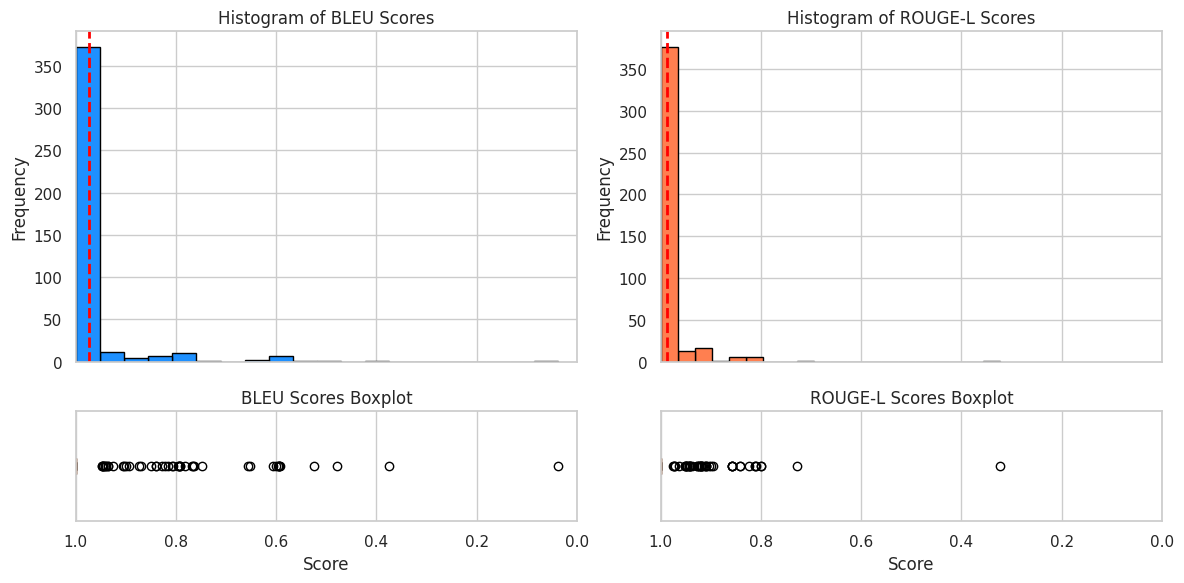

In [61]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_hist_and_box(bleu_scores, rouge_scores, bins=20):
    """
    Plots two columns:
      - Left column: BLEU histogram on top, BLEU boxplot on bottom.
      - Right column: ROUGE-L histogram on top, ROUGE-L boxplot on bottom.
    
    The x-axis represents the raw score (reversed from 1 to 0) and two trendy colors are used:
      - BLEU: dodgerblue
      - ROUGE-L: coral
    
    Parameters:
      bleu_scores (array-like): List or array of BLEU scores.
      rouge_scores (array-like): List or array of ROUGE-L scores.
      bins (int): Number of bins for the histograms.
    """
    # Create a 2x2 grid with custom height ratios (histogram taller than boxplot)
    fig, axes = plt.subplots(
        2, 2,
        figsize=(12, 6),
        gridspec_kw={'height_ratios': [3, 1]},
        sharex='col'
    )
    
    # --- Column 1: BLEU Scores ---
    # Top: Histogram
    axes[0, 0].hist(bleu_scores, bins=bins, color='dodgerblue', edgecolor='black')
    axes[0, 0].set_title("Histogram of BLEU Scores")
    axes[0, 0].set_ylabel("Frequency")
    
    # Compute and annotate the mean value for BLEU scores
    mean_bleu = np.mean(bleu_scores)
    print('mean_bleu:', mean_bleu)
    axes[0, 0].axvline(mean_bleu, color='red', linestyle='dashed', linewidth=2)

    # Bottom: Boxplot
    axes[1, 0].boxplot(bleu_scores, vert=False, patch_artist=True,
                       boxprops=dict(facecolor='dodgerblue', color='black'))
    axes[1, 0].set_title("BLEU Scores Boxplot")
    axes[1, 0].set_yticks([])  # Remove y-axis ticks for a cleaner look
    axes[1, 0].set_xlabel("Score")
    
    # --- Column 2: ROUGE-L Scores ---
    # Top: Histogram
    axes[0, 1].hist(rouge_scores, bins=bins, color='coral', edgecolor='black')
    axes[0, 1].set_title("Histogram of ROUGE-L Scores")
    axes[0, 1].set_ylabel("Frequency")

    # Compute and annotate the mean value for ROUGE-L scores
    mean_rouge = np.mean(rouge_scores)
    print('mean_rouge:', mean_rouge)
    axes[0, 1].axvline(mean_rouge, color='red', linestyle='dashed', linewidth=2)
    
    # Bottom: Boxplot
    axes[1, 1].boxplot(rouge_scores, vert=False, patch_artist=True,
                       boxprops=dict(facecolor='coral', color='black'))
    axes[1, 1].set_title("ROUGE-L Scores Boxplot")
    axes[1, 1].set_yticks([])
    axes[1, 1].set_xlabel("Score")
    
    # Reverse x-axis so that scores are shown from 1 to 0.
    for ax in axes.flat:
        ax.set_xlim(1, 0)
    
    plt.tight_layout()
    plt.show()

plot_hist_and_box(bleu, rough_l)

# Plot on Turning Points

In [5]:
import numpy as np

def aggregate_scores(list_of_data, score_types=['acc2', 'acc3', 'jcc']):
    """
    Given a list (e.g., 5 elements) where each element is a list of layers.
    Each layer is a list of dictionaries (e.g., 4 objects) and each dictionary 
    has keys (e.g., "acc2", "acc3", "jcc") mapping to a list of scores of length 2,
    this function computes, for each score type, a final 3x2 array of mean values.
    
    The mean is computed across all dictionaries in a layer and across all data elements.
    
    Returns:
        A dictionary mapping each score type to a numpy array of shape (num_layers, num_items)
        with the aggregated means.
    """
    # Assume all data elements have the same shape.
    num_layers = len(list_of_data[0])       # e.g., 3 layers
    # We assume that each dictionary's value is a list of length 2.
    num_items = len(list_of_data[0][0][0][score_types[0]])
    
    final_means = {score: np.zeros((num_layers, num_items)) for score in score_types}
    
    # For each score type, each layer, and each item, average over all dictionaries in that layer across all data.
    for score in score_types:
        for layer_idx in range(num_layers):
            # Collect all scores from all dictionaries in this layer across every data element.
            values = []
            for data in list_of_data:
                layer = data[layer_idx]  # a list of dictionaries for this layer
                for d in layer:
                    # d[score] is a list of length num_items; take the item at index item_idx.
                    values.append(d[score])
            # Now, values is a list of lists (each inner list of length num_items) coming from
            # (num_data_elements * num_objects) dictionaries.
            # Convert to numpy array and compute mean over axis 0.
            values = np.array(values)  # shape (n_total, num_items)
            mean_by_item = np.mean(values, axis=0)  # shape (num_items,)
            final_means[score][layer_idx, :] = mean_by_item
    
    return final_means

In [18]:
example_data = []
for _ in range(2):  # 5 data structures
    layers = []
    for _ in range(1):  # 2 layers
        layer = []
        for _ in range(4):  # 2 dictionaries per layer
            d = {
                "acc2": np.random.rand(2).tolist(),  # two scores
                "acc3": np.random.rand(2).tolist(),
                "jcc":  np.random.rand(2).tolist()
            }
            layer.append(d)
        layers.append(layer)
    example_data.append(layers)

final = aggregate_scores(example_data, score_types=['acc2', 'acc3', 'jcc'])
for score, matrix in final.items():
    print(f"{score}:")
    print(matrix)

acc2:
[[0.51484684 0.3705909 ]]
acc3:
[[0.48382586 0.59960769]]
jcc:
[[0.50745817 0.448386  ]]


In [90]:
def elementwise_mean(matrices):
    # Stack the matrices along a new axis, then compute the mean along that axis.
    matrices = np.array(matrices)
    stacked = np.stack(matrices)
    return np.mean(stacked, axis=0)
elementwise_mean([[1,2],
                  [2,3]])

array([1.5, 2.5])

In [147]:
import numpy as np
def elementwise_mean(matrices):
    # Stack the matrices along a new axis, then compute the mean along that axis.
    matrices = np.array(matrices)
    stacked = np.stack(matrices)
    return np.mean(stacked, axis=0)

def del_all_0(lst):
    _lst = [0]*len(lst)
    return lst==_lst

def get_mat_cg(data_lst, score_types, tokens=20):        
    # Compute the mean matrix for each score type
    matrices = {}
    for score in score_types:
        score_ult = []
        for data in data_lst:
            score_data = []
            for layer in data:
                # values = [d[score][0][0] for d in layer if not del_all_0(d[score][0][0])]
                values = [d[score][0][0] for d in layer]
                score_data.append(elementwise_mean(values))
            score_ult.append(score_data)
        matrices[score] = elementwise_mean(score_ult)[0]
        matrices[f'{score}_template'] = score_ult
    return matrices

data = get_mat_cg(loaded_data, score_types=['jcc_all', 'acc_all'])

In [148]:
def plot_hist_and_box(bleu_scores, rouge_scores, bins=10):
    """
    Plots two columns:
      - Left column: BLEU histogram on top, BLEU boxplot on bottom.
      - Right column: ROUGE-L histogram on top, ROUGE-L boxplot on bottom.
    
    The x-axis represents the raw score (reversed from 1 to 0) and two trendy colors are used:
      - BLEU: dodgerblue
      - ROUGE-L: coral
    
    Parameters:
      bleu_scores (array-like): List or array of BLEU scores.
      rouge_scores (array-like): List or array of ROUGE-L scores.
      bins (int): Number of bins for the histograms.
    """
    # Create a 2x2 grid with custom height ratios (histogram taller than boxplot)
    fig, axes = plt.subplots(
        2, 2,
        figsize=(12, 6),
        gridspec_kw={'height_ratios': [3, 1]},
        sharex='col'
    )
    
    # --- Column 1: BLEU Scores ---
    # Top: Histogram
    axes[0, 0].hist(bleu_scores, bins=bins, color='dodgerblue', edgecolor='black')
    axes[0, 0].set_title("Histogram of BLEU Scores")
    axes[0, 0].set_ylabel("Frequency")
    
    # Compute and annotate the mean value for BLEU scores
    mean_bleu = np.mean(bleu_scores)
    axes[0, 0].axvline(mean_bleu, color='red', linestyle='dashed', linewidth=2)

    # Bottom: Boxplot
    axes[1, 0].boxplot(bleu_scores, vert=False, patch_artist=True,
                       boxprops=dict(facecolor='dodgerblue', color='black'))
    axes[1, 0].set_title("BLEU Scores Boxplot")
    axes[1, 0].set_yticks([])  # Remove y-axis ticks for a cleaner look
    axes[1, 0].set_xlabel("Score")
    
    # --- Column 2: ROUGE-L Scores ---
    # Top: Histogram
    axes[0, 1].hist(rouge_scores, bins=bins, color='coral', edgecolor='black')
    axes[0, 1].set_title("Histogram of ROUGE-L Scores")
    axes[0, 1].set_ylabel("Frequency")

    # Compute and annotate the mean value for ROUGE-L scores
    mean_rouge = np.mean(rouge_scores)
    axes[0, 1].axvline(mean_rouge, color='red', linestyle='dashed', linewidth=2)
    
    # Bottom: Boxplot
    axes[1, 1].boxplot(rouge_scores, vert=False, patch_artist=True,
                       boxprops=dict(facecolor='coral', color='black'))
    axes[1, 1].set_title("ROUGE-L Scores Boxplot")
    axes[1, 1].set_yticks([])
    axes[1, 1].set_xlabel("Score")
    
    # Reverse x-axis so that scores are shown from 1 to 0.
    for ax in axes.flat:
        ax.set_xlim(1, 0)
    
    plt.tight_layout()
    plt.show()

{'jcc_all': array([0.90671605, 0.90677765, 0.90372069, 0.90308286, 0.89333932,
        0.89219716, 0.88990893, 0.89149803, 0.89285766, 0.89499954,
        0.89079229, 0.89590942, 0.89287321, 0.88708383, 0.88272454,
        0.88595595, 0.89199545, 0.89348883, 0.89023842, 0.8940876 ,
        0.88413408]),
 'jcc_all_template': [[array([0.9042439 , 0.90052764, 0.90921684, 0.9143923 , 0.90565239,
          0.90512552, 0.89283131, 0.90851333, 0.89485868, 0.90443677,
          0.90035763, 0.90599488, 0.8964419 , 0.90536629, 0.89372452,
          0.90045306, 0.90627183, 0.89743887, 0.89980003, 0.89682229,
          0.89757066])],
  [array([0.915286  , 0.91847831, 0.93323253, 0.93190103, 0.92710945,
          0.92374612, 0.91339817, 0.92166444, 0.92099198, 0.92545142,
          0.92272899, 0.92021055, 0.92603086, 0.91324484, 0.91229974,
          0.92127467, 0.92169823, 0.91882612, 0.91791601, 0.91545223,
          0.91304795])],
  [array([0.89171897, 0.91395352, 0.86724583, 0.8681327 , 0.86024

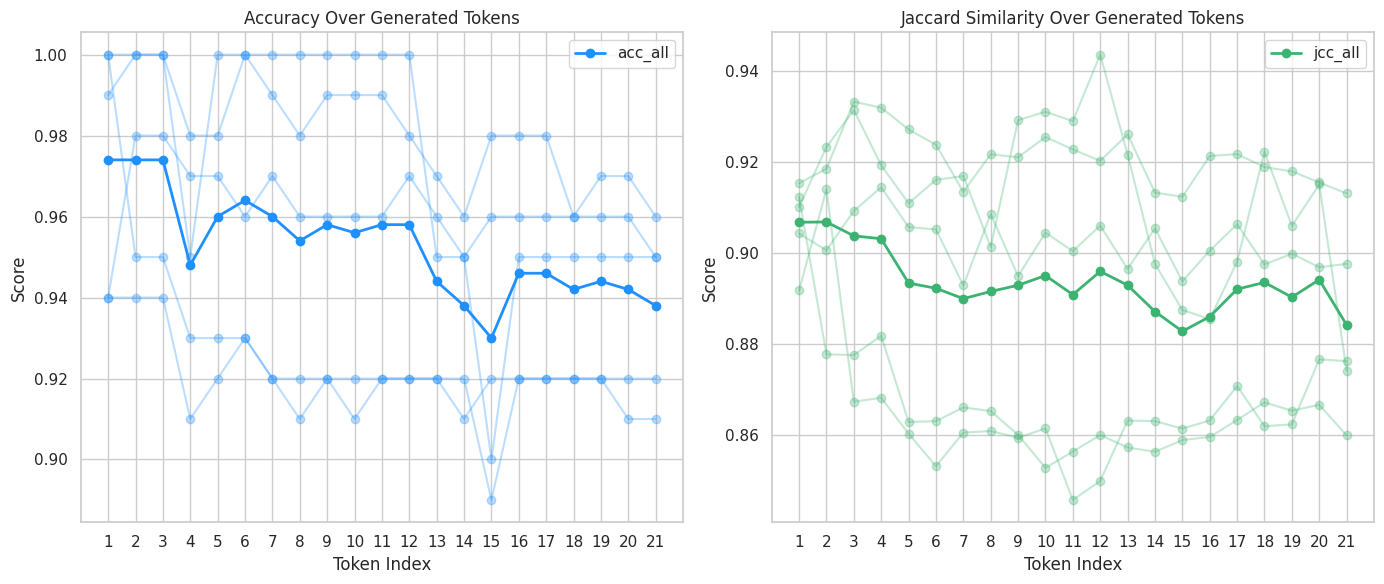

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_token_scores(data):
    """
    Given a data dictionary containing two metrics for continuous generation:
      - 'acc_all': a 1D numpy array (length n) representing the average acc scores.
      - 'acc_all_template': a list of lists (each with one numpy array of length n) 
          representing individual template acc scores.
      - 'jcc_all': a 1D numpy array (length n) representing the average jcc scores.
      - 'jcc_all_template': a list of lists (each with one numpy array of length n)
          representing individual template jcc scores.
          
    This function creates two subplots (one for each metric). In each subplot:
      - The main (average) line is plotted in a solid, prominent color.
      - Each template line is overlaid with the same color but with lower transparency.
      - The x-axis shows token indices from 1 to n.
      
    Parameters:
      data (dict): A dictionary with keys 'acc_all', 'acc_all_template', 'jcc_all', and 'jcc_all_template'.
    """
    # Determine the number of tokens from the average array (assumes acc_all and jcc_all have same length)
    n = len(data['acc_all'])
    tokens = np.arange(1, n + 1)
    
    # Set a trendy seaborn theme
    sns.set_theme(style="whitegrid")
    
    # Create subplots for the two metrics: ACC and JCC
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # --- Plot for ACC ---
    ax = axs[0]
    # Plot the main acc line
    ax.plot(tokens, data['acc_all'], label='acc_all', color='dodgerblue', marker='o', linewidth=2)
    # Plot each template in acc_all_template with lower transparency
    for template in data['acc_all_template']:
        # Each template is assumed to be a list with one array element.
        template_line = template[0]
        ax.plot(tokens, template_line, color='dodgerblue', marker='o', alpha=0.3)
    ax.set_xlabel("Token Index")
    ax.set_ylabel("Score")
    ax.set_title("Accuracy Over Generated Tokens")
    ax.legend()
    
    # --- Plot for JCC ---
    ax = axs[1]
    # Plot the main jcc line
    ax.plot(tokens, data['jcc_all'], label='jcc_all', color='mediumseagreen', marker='o', linewidth=2)
    # Plot each template in jcc_all_template with lower transparency
    for template in data['jcc_all_template']:
        template_line = template[0]
        ax.plot(tokens, template_line, color='mediumseagreen', marker='o', alpha=0.3)
    ax.set_xlabel("Token Index")
    ax.set_ylabel("Score")
    ax.set_title("Jaccard Similarity Over Generated Tokens")
    ax.legend()
    
    # Set x-axis ticks from 1 to n (integer labels)
    for ax in axs:
        ax.set_xticks(np.arange(1, n + 1))
        ax.set_xticklabels(np.arange(1, n + 1))
    
    plt.tight_layout()
    plt.show()


plot_token_scores(data)

In [120]:
from utils import misc
task_name = 'continue_generation'
# loaded_data = misc.load_dict_from_json(f"output/copy_mode/copy_mode_swap_a_the.json")
loaded_data = misc.load_json_files(f"output/continue_generation")

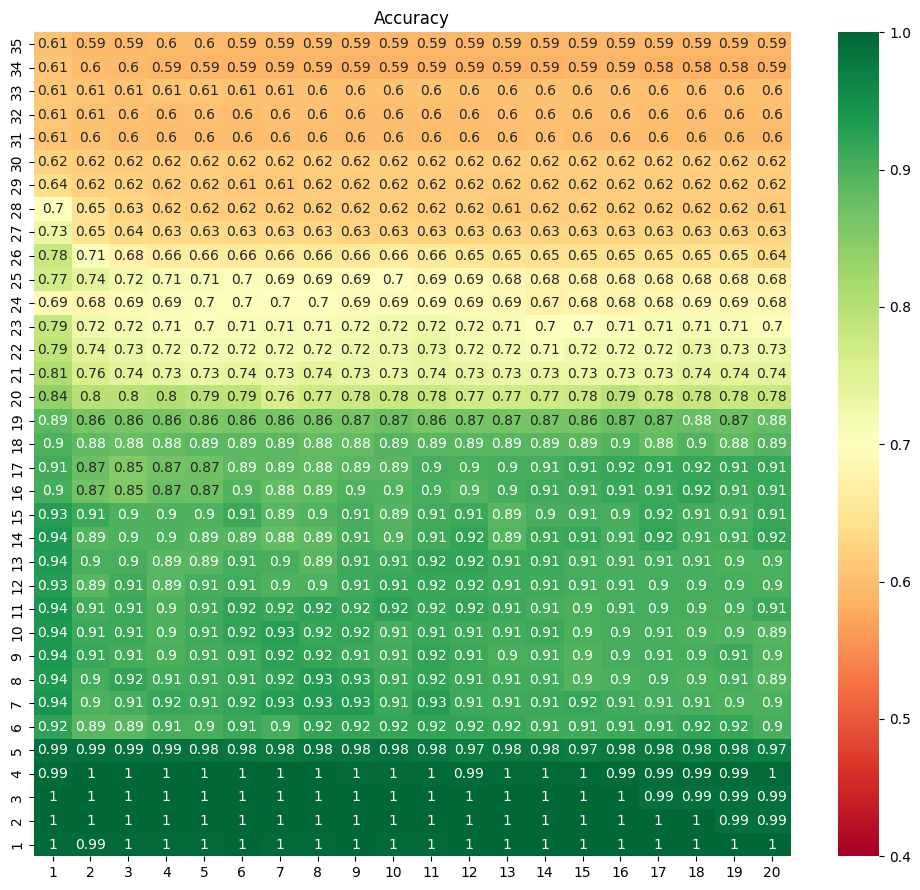

In [3]:
from utils import misc
task_name = 'turning_points'
# loaded_data = misc.load_dict_from_json(f"output/copy_mode/copy_mode_swap_a_the.json")
loaded_data = misc.load_json_files(f"output/turning_points")
misc.plot_score_heatmaps(loaded_data, score_types=['acc2'])

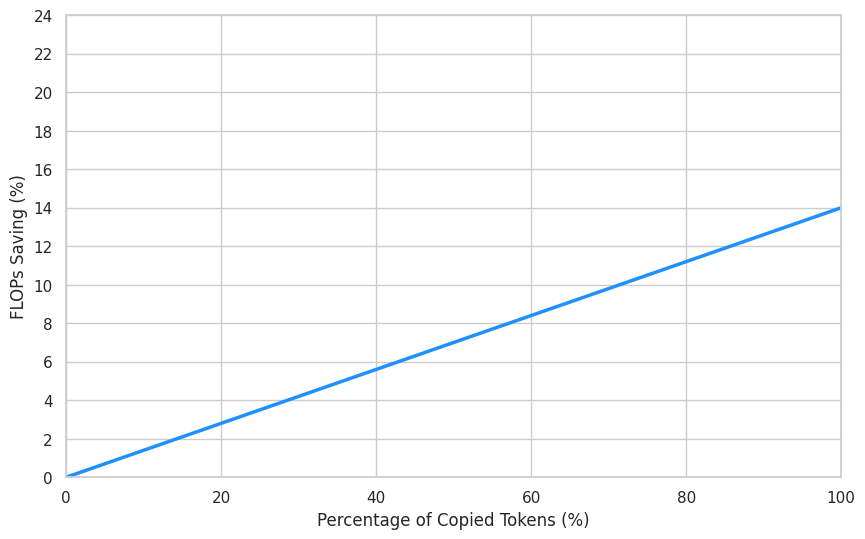

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_flops_saving_line():
    """
    Plots a line chart where:
      - x-axis: Percentage of copied tokens (0 to 100)
      - y-axis: FLOPs saving (0 to 24), with a line that goes from 0 to 14.
    The y-axis ticks have a step of 2.
    """
    # Set the theme using Seaborn for a modern appearance.
    sns.set_theme(style="whitegrid")
    
    # Generate x values: percentage of copied tokens from 0 to 100.
    x = np.linspace(0, 100, 101)
    
    # Define a linear relationship for FLOPs saving such that:
    # when x = 0, y = 0 and when x = 100, y = 14.
    y = (14 / 100) * x
    
    # Create the figure.
    plt.figure(figsize=(10, 6))
    
    # Plot the line using Seaborn's lineplot with the specified color.
    sns.lineplot(x=x, y=y, color="dodgerblue", linewidth=2.5)
    
    # Set the x-axis limits (0 to 100) and y-axis limits (0 to 24).
    plt.xlim(0, 100)
    plt.ylim(0, 24)
    
    # Set y-axis ticks in increments of 2.
    plt.yticks(np.arange(0, 25, 2))
    
    # Label the axes and provide a title.
    plt.xlabel("Percentage of Copied Tokens (%)", fontsize=12)
    plt.ylabel("FLOPs Saving (%)", fontsize=12)
    # plt.title("FLOPs Saving vs. Percentage of Copied Tokens", fontsize=14, fontweight='bold')
    
    # Display the plot.
    plt.show()

# Call the function to display the plot.
plot_flops_saving_line()
